In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(); sns.set_context('paper')
import os

In [11]:
so_df = pd.DataFrame()

for so in ['3492','3497','3500','3555','3561','3563','3574','3582']:
    temp_df = pd.read_csv(filepath_or_buffer=os.getcwd().replace("notebooks","csv\\") + so + ".csv", header=0, index_col=False)
    so_df = pd.concat([so_df,temp_df], ignore_index=True)
    
so_df['SO_Number'] = so_df['JobNum'].str[0:4]
so_df

,JobNum,LotNum,DrawNum,PartDescription,TranQty,QtyCompleted,PhaseID,OrigProdQty,AQLAmount,AQLforTranQty,SO_Number
0,3492-01-1,NV10200,1541900,5.5 Poly Tulip 5.5 Ti,27.0,549.0,Tulip,500.0,29.0,1.426230,3492
1,3492-01-1,NV10458,1541901,5.5mm Load Ring Ti,27.0,550.0,Load Ring,500.0,29.0,1.423636,3492
2,3492-01-1,NV14430,1567720,6.5 x 50mm Fenestrated Shank,27.0,83.0,Shank,25.0,13.0,4.228916,3492
3,3492-01-1,NV14629,1541902,"Deformity Poly Split Ring, Ti",27.0,604.0,Clip/Split Ring,500.0,29.0,1.296358,3492
4,3492-02-1,NV10937,1553262,5.5mm Precept Polyaxial Tulip,220.0,550.0,Tulip,500.0,29.0,11.600000,3492
...,...,...,...,...,...,...,...,...,...,...,...
685,3582-15-1,NV15297,1590480,7.5 x 50mm Precept Screw Shank,139.0,219.0,Shank,180.0,20.0,12.694064,3582
686,3582-16-1,NV14649,1582023,Precept Poly C.R. Load Ring,52.0,550.0,Load Ring,500.0,29.0,2.741818,3582
687,3582-16-1,NV14657,1582022,Precept Poly Clip Ring,52.0,1637.0,Clip/Split Ring,1000.0,34.0,1.080024,3582
688,3582-16-1,NV14670,1582025,Precept Poly C.R. Tulip,52.0,650.0,Tulip,500.0,29.0,2.320000,3582


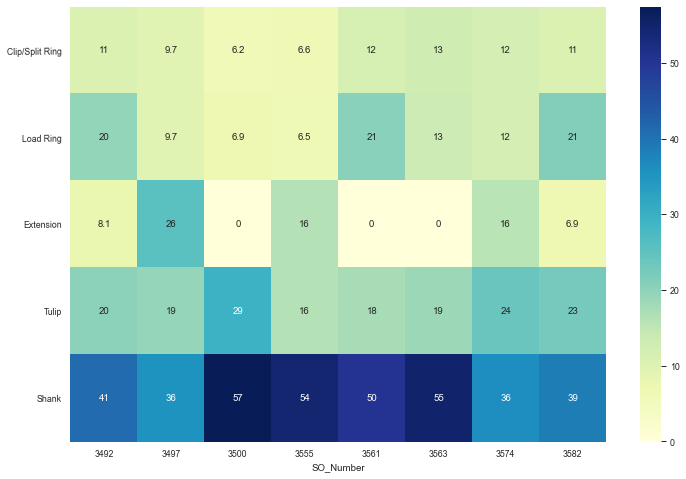

In [65]:



pivot_df = so_df.pivot_table(values='AQLforTranQty',index='PhaseID',columns='SO_Number',aggfunc=np.sum, fill_value=0)
pivot_df = pivot_df.reindex(['Clip/Split Ring','Load Ring','Extension','Tulip','Shank'],)

# for a in pivot_df.columns.to_list():
#     pivot_df[a].apply(lambda x: x **2)
    
pivot_df = pivot_df.apply(func=lambda x: 100*x/x.sum(), axis=0)
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(pivot_df,cmap='YlGnBu', ax=ax,annot=True)
ax.set_ylabel('')
ax.tick_params(axis='y', labelrotation=.5)


In [40]:
so_3497 = so_df[so_df['JobNum'].str.contains('3497')]

so_3497.groupby(by='PhaseID').aggregate({'AQLforTranQty':np.sum})

,AQLforTranQty
PhaseID,
Clip/Split Ring,66.577514
Extension,175.638141
Load Ring,66.203137
Shank,243.590407
Tulip,133.439420


## 3497 Testing

In [2]:
# os.getcwd().replace("notebooks","csv\\")
df3497 = pd.read_csv(filepath_or_buffer=os.getcwd().replace("notebooks","csv\\") + "3497.csv", header=0, index_col=False)
df3497

,JobNum,LotNum,DrawNum,PartDescription,TranQty,QtyCompleted,PhaseID,OrigProdQty,AQLAmount,AQLforTranQty
0,3497-01-2,NV13007,1751200,5.5 x 50mm Cannulated Cancellous Shank,40.0,68.0,Shank,25.0,13.0,7.647059
1,3497-01-2,NV13687,1642646,Reline Breakoff Extension,40.0,275.0,Extension,250.0,20.0,2.909091
2,3497-01-2,NV13727,1642652,Reline MAS Reduction Tulip Base,40.0,274.0,Tulip,250.0,20.0,2.919708
3,3497-01-2,NV14174,1642661,Reline Poly Load Ring,40.0,1100.0,Load Ring,1000.0,34.0,1.236364
4,3497-01-2,NV14394,1642666,Reline Clip Ring Flat,44.0,1100.0,Clip/Split Ring,1000.0,34.0,1.360000
...,...,...,...,...,...,...,...,...,...,...
105,3497-16-1,NV13786,1642666,Reline Clip Ring Flat,28.0,1045.0,Clip/Split Ring,1000.0,34.0,0.911005
106,3497-16-1,NV13866,1642646,Reline Breakoff Extension,28.0,275.0,Extension,250.0,20.0,2.036364
107,3497-16-1,NV13868,1642652,Reline MAS Reduction Tulip Base,28.0,275.0,Tulip,250.0,20.0,2.036364
108,3497-16-1,NV14391,1642661,Reline Poly Load Ring,28.0,1100.0,Load Ring,1000.0,34.0,0.865455


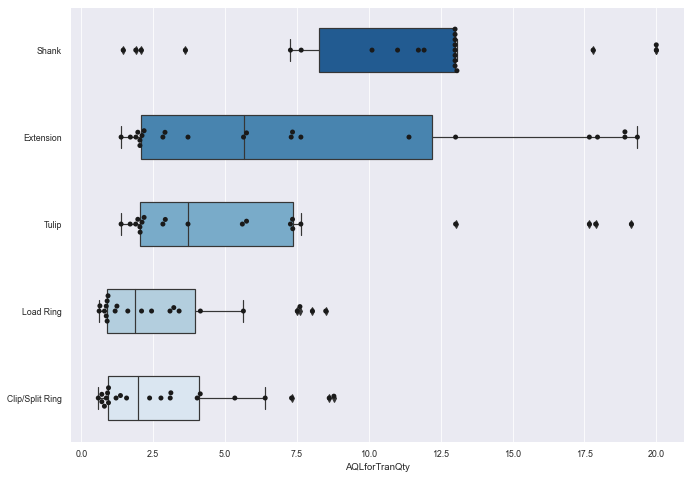

In [4]:
fig,ax = plt.subplots(figsize=(11,8))
ax.yaxis.label.set_visible(False)
ax = sns.boxplot(x='AQLforTranQty',y='PhaseID', data=df3497, ax=ax, palette='Blues_r', width=.5, whis=.75)
ax = sns.swarmplot(x='AQLforTranQty',y='PhaseID', data=df3497, ax=ax, color='k')

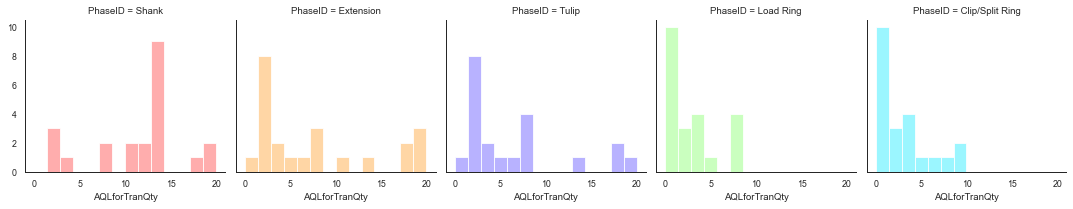

In [5]:
with sns.axes_style(style='white'):
    grid = sns.FacetGrid(df3497, col='PhaseID',sharey=True, hue='PhaseID', palette=['#FFADAD','#FFD6A5','#B8B2FF','#CAFFBF','#9BF6FF'])
    grid.map(plt.hist, 'AQLforTranQty', bins=np.linspace(0,20,15))
    

In [6]:
df3497_sorted = df3497.sort_values(by=['PhaseID','AQLforTranQty'],axis=0,ascending=True)



<AxesSubplot:ylabel='AQLforTranQty'>

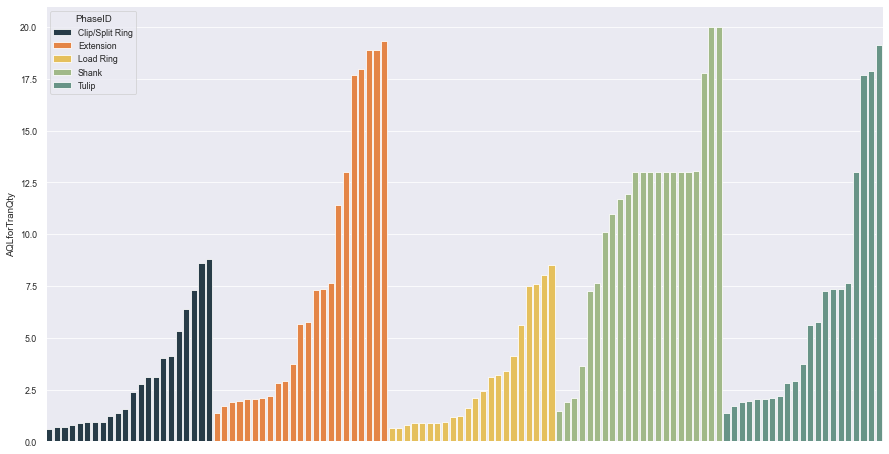

In [7]:

fig, ax = plt.subplots(figsize=(15,8))
# ax.set_facecolor('white')
ax.set_xticklabels(labels=[],visible=False)
sns.barplot(x=np.arange(0,110,1),y='AQLforTranQty', data=df3497_sorted, hue='PhaseID', 
            palette=['#233D4D','#FE7F2D','#FCCA46','#A1C181','#619B8A'], ax=ax, dodge=False)

In [9]:
# df3574 = pd.read_csv(filepath_or_buffer=os.getcwd().replace('notebooks', 'csv\\3574.csv'),header=0, index_col=None)

df3497.groupby(by='PhaseID').aggregate({'AQLforTranQty':np.sum})

,AQLforTranQty
PhaseID,
Clip/Split Ring,66.577514
Extension,175.638141
Load Ring,66.203137
Shank,243.590407
Tulip,133.439420
